# Object detection

Using the MNIST dataset, we will place numbers on different parts of a canvas. Then our model will put a bounding box around the numbers and also detect what number is inside. I would also like for the model to be able to identiy multiple numbers in the same picture if they are visible while also ignoring noise, like lines or symbols.

## 1. Dataset
The MNIST dataset has all the numbers in the center of the screen, we will need to make these images.

1. Using a black canvas we will place between 1 and 5 MNIST digits on the canvas on random locations
2. The digits will vary in size and the images will be rotated up to 10 degrees for variance
3. We will track the location of the bounding box
4. Save: image + labels (digit_class, x, y, width, height)

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torchvision
import torchvision.transforms as transforms
from PIL import Image, ImageDraw
import random
import math

In [3]:
def load_mnist_data():
    transform = transforms.Compose([transforms.ToTensor()])

    train_dataset = torchvision.datasets.MNIST(
        root='./data',
        train=True,
        download=True,
        transform=transform
    )

    test_dataset = torchvision.datasets.MNIST(
        root='./data',
        train=False,
        download=True,
        transform=transform
    )

    return train_dataset, test_dataset

In [9]:
class DigitPlacer:
    def __init__(self, canvas_size=224, min_digit_size=20, max_digit_size=40, max_rotation=10):
        self.canvas_size = canvas_size
        self.min_digit_size = min_digit_size
        self.max_digit_size = max_digit_size
        self.max_rotation = max_rotation

    def process_single_digit(self, mnist_image, target_size=None, rotation_angle=None):
        mnist_array = mnist_image.squeeze().numpy() # Tensor to image
        mnist_array = (mnist_array * 255).astype(np.uint8) 

        digit_pil = Image.fromarray(mnist_array, mode='L')

        if target_size is None:
            target_size = random.randint(self.min_digit_size, self.max_digit_size)

        if rotation_angle is None:
            rotation_angle = random.uniform(-self.max_rotation, self.max_rotation)

        digit_resized = digit_pil.resize((target_size, target_size), Image.Resampling.LANCZOS)
        digit_rotated = digit_resized.rotate(rotation_angle, expand=True, fillcolor=0)

        return digit_rotated, target_size, rotation_angle
    
    def place_digit_on_canvas(self, canvas, digit_image, position=None):
        digit_width, digit_height = digit_image.size
        canvas_width, canvas_height = canvas.size

        if position is None:
            max_X = canvas_width - digit_width
            max_Y = canvas_height - digit_height

            x = random.randint(0, max_X)
            y = random.randint(0, max_Y)
        else:
            x, y = position

        canvas.paste(digit_image, (x,y))

        return (x, y, digit_width, digit_height)


In [14]:
canvas = Image.new('RGB', (224, 224), color=(0, 0, 0))
placer = DigitPlacer(224)
annotations = [] # Empty array for annotations

train_dataset, test_dataset = load_mnist_data()

for i in range(5):
    idx = random.randint(0, len(train_dataset) - 1)
    mnist_image, digit_class = train_dataset[idx]

    processed_digit, size, rotation = placer.process_single_digit(mnist_image)
    bbox = placer.place_digit_on_canvas(canvas, processed_digit)

    if bbox is not None:
        #x, y, width, height = bbox
        annotations.append({
            'class':digit_class,
            'bbox': bbox,
            'size': size,
            'rotation': rotation
        })

C:\Users\filip\AppData\Local\Temp\ipykernel_3032\2058649569.py:12: DeprecationWarning: 'mode' parameter is deprecated and will be removed in Pillow 13 (2026-10-15)
  digit_pil = Image.fromarray(mnist_array, mode='L')


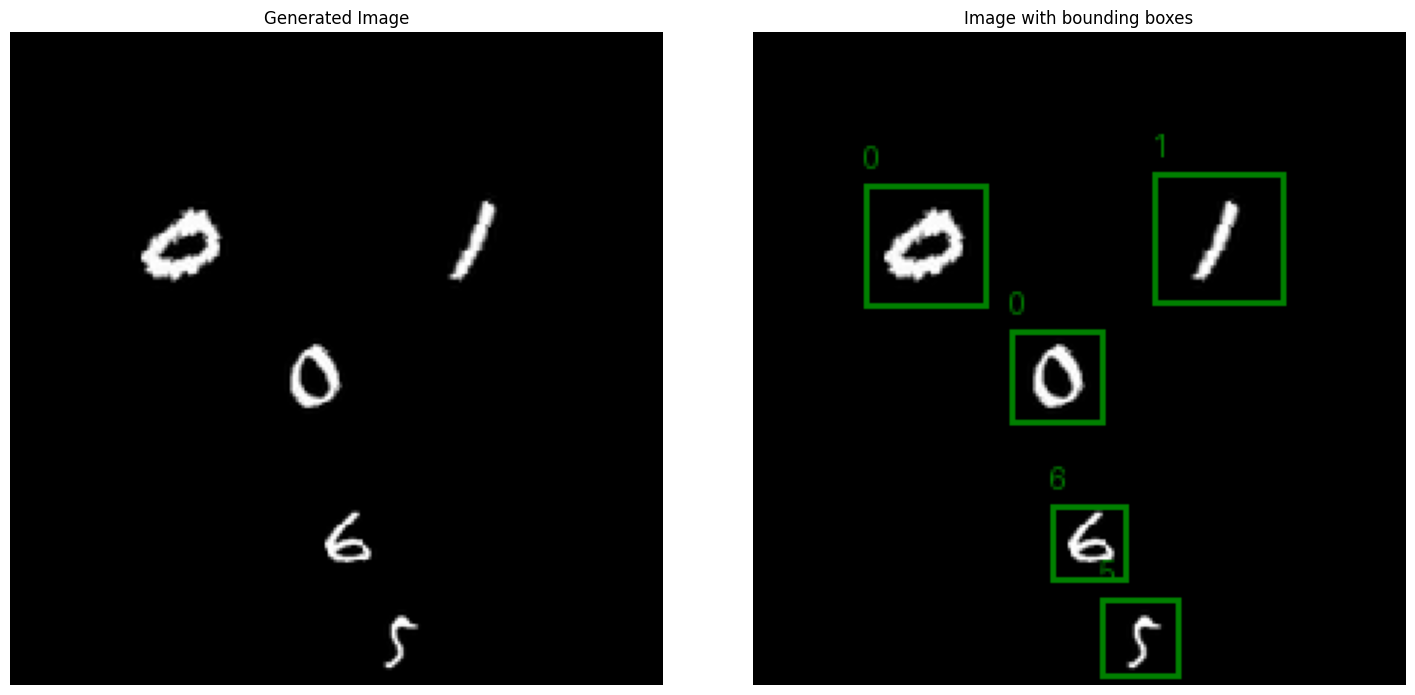

In [15]:
canvas_with_bbox = canvas.copy()
draw = ImageDraw.Draw(canvas_with_bbox)

for i, ann in enumerate(annotations):
    digit_class = ann['class']
    x, y, width, height = ann['bbox']

    # Draw rectangle
    draw.rectangle([x, y, x+width, y+height], outline='green', width=2)
    label = f'{digit_class}'
    draw.text((x, y-15), label, fill='green')

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 7))

# Original image
ax1.imshow(canvas)
ax1.set_title("Generated Image")
ax1.axis('off')

# Image with boudning box
ax2.imshow(canvas_with_bbox)
ax2.set_title("Image with bounding boxes")
ax2.axis('off')

plt.tight_layout()
plt.show()

## 2. Object Detection architecture
In classification the model takes one image and makes a prediction.
In detection we also have to figure out where something is. We will need to first perform feature extraction, then detect and see if we can identify something. 

The backbone of Feature Extraction is CNN - Convolutional Neural Network which basically means that a Convolutional layer - or layers - perform feature extraction on the input.

## 3. Loss function

Until now the loss function was just a product of the confidence and classofication loss, but now it will need to also include a localisation loss

1. Localisation loss - MSE between predicted (x,y,w,h) and true (x,y,w,h)
2. Classification loss - CrossEntropy between predicted class and true class
3. Confidence loss - 
    for cells **WITH** objects: BCE(predicted_conf, 1)
    for cells **WITHOUT** objects: BCE(predicted_conf, 0)
